In [26]:
import yaml
import awkward as aw
import uproot
import hist
import math
import numpy as np
from scipy.stats import kstest
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from IPython.display import Audio
from matplotlib.offsetbox import AnchoredText
import joblib
from util import * 

import random
import time

import seaborn as sns
import matplotlib.pyplot as plt
import cloudpickle
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay,  classification_report

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


In [2]:
datasets = ['frvz_ggf_508885', 'frvz_ggf_508886', 'frvz_ggf_508887', 'frvz_ggf_508888', 'frvz_ggf_508889', 'frvz_ggf_508890', 'frvz_ggf_508891',
            'frvz_ggf_508892', 'frvz_ggf_508893', 'frvz_vbf_500757_02-00', 'frvz_vbf_500758_02-00',
            'frvz_vbf_500759_02-00', 'frvz_vbf_500760_02-00', 'frvz_vbf_500761_02-00', 'frvz_vbf_500762_02-00', 'frvz_vbf_500763_02-00', 'frvz_vbf_500764_02-00']

BDT_inputs = ['mjj', "dphijj", "detajj",
              'MET',
              'jet1_pt',
              'jet1_eta',
              'jet1_e',
              'jet2_pt',
              'jet2_eta',
              'jet2_e',
                "njet30", 
            #  "centrality"
            'intLumi',
            'scale1fb'
             ]

In [3]:
df = read_data(datasets = datasets, variables=BDT_inputs, carpeta='C:/Users/jav90/Desktop/dpj/production_analysis/analisis_javier/Samples/')

frvz_ggf_508885
frvz_ggf_508886
frvz_ggf_508887
frvz_ggf_508888
frvz_ggf_508889
frvz_ggf_508890
frvz_ggf_508891
frvz_ggf_508892
frvz_ggf_508893
frvz_vbf_500757_02-00
frvz_vbf_500758_02-00
frvz_vbf_500759_02-00
frvz_vbf_500760_02-00
frvz_vbf_500761_02-00
frvz_vbf_500762_02-00
frvz_vbf_500763_02-00
frvz_vbf_500764_02-00


In [4]:
df1 = df.copy()
df1 = df1[df1['weights'] >= 0] #eliminar weights negativos y ceros
df1['VBF label'] = df1['tipo'].apply(lambda x: 1 if x == 'vbf' else 0) #crear columna con 1 para vbf y 0 para ggf


In [5]:
df.shape

(4628576, 15)

In [7]:
ml_var = ['mjj', "dphijj", "detajj", 'MET',
              'jet1_pt',
              'jet1_eta',
              'jet1_e',
              'jet2_pt',
              'jet2_eta',
              'jet2_e',
              'njet30']



X_ggf = df1[df1['tipo'] == 'ggf'].sample(n=2000000, random_state=228)
X_ggf = X_ggf[X_ggf['njet30'] > 1]

X_vbf = df1[df1['tipo'] == 'vbf']
X_ggf_vbf = pd.concat([X_ggf, X_vbf], axis=0)
X = X_ggf_vbf[ml_var]
y = X_ggf_vbf['VBF label']


In [8]:
print(X_ggf.shape)
print(X_vbf.shape)


(736060, 16)
(491044, 16)


In [9]:
X_ggf_vbf

,mjj,dphijj,detajj,MET,jet1_pt,jet1_eta,jet1_e,jet2_pt,jet2_eta,jet2_e,njet30,intLumi,scale1fb,weights,tipo,VBF label
1922897,4.135178e+04,-1.388952,0.015607,39954.585938,31994.083984,0.574745,3.799173e+04,30211.220703,0.590351,3.592268e+04,2,36.099998,0.041837,1.510301,ggf,0
2076601,2.022060e+05,2.939579,1.369800,99959.726562,118938.937500,0.153307,1.219211e+05,54682.148438,-1.216493,1.008361e+05,6,44.299999,0.000452,0.020022,ggf,0
4102287,6.640849e+05,2.925986,5.606311,16936.062500,48726.402344,2.052103,1.928805e+05,33005.652344,-3.554208,5.774382e+05,2,58.450001,0.031009,1.812492,ggf,0
1028220,6.245890e+04,0.889752,1.364045,69531.718750,36784.332031,2.508739,2.275718e+05,35335.957031,1.144695,6.129078e+04,2,36.099998,0.045243,1.633280,ggf,0
1920149,1.074340e+05,2.418122,1.041257,17352.517578,60429.839844,0.916951,8.790906e+04,39658.742188,-0.124306,4.094811e+04,2,36.099998,0.040848,1.474623,ggf,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628571,1.367926e+06,0.648911,4.957650,216401.265625,116440.851562,-3.211884,1.447791e+06,114172.210938,1.745765,3.373078e+05,2,36.099998,0.000256,0.009256,vbf,1
4628572,1.540464e+06,-0.568785,5.033163,191440.421875,134930.218750,3.088001,1.482836e+06,115863.156250,-1.945162,4.136839e+05,3,36.099998,0.000305,0.011002,vbf,1
4628573,1.694813e+06,-2.918931,5.825066,35132.878906,110081.000000,3.609008,2.034103e+06,76587.546875,-2.216058,3.554840e+05,2,1.000000,0.000271,0.000271,vbf,1
4628574,7.387971e+05,0.789625,5.037199,97912.656250,105132.671875,-0.351721,1.122496e+05,33879.730469,4.685478,1.835801e+06,3,36.099998,0.000282,0.010165,vbf,1


In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=228)

In [16]:
params = { "n_estimators": 800,
            "max_depth": 12,
            "learning_rate": 0.5,
            "gamma": 0.6,
            "min_child_weight": 1,
            "reg_lambda": 100,
          #  "scale_pos_weight": scale_pos_weight,
            "eval_metric": ["logloss", "auc"],
            "early_stopping_rounds": 5,
            "objective":"binary:logistic",
            "verbosity": 1
            }

model = xgb.XGBClassifier(**params)

In [17]:
y_train

3556267    0
4600529    1
2212861    0
260032     0
4516133    1
          ..
2602793    0
3371629    0
343341     0
1198883    0
4427099    1
Name: VBF label, Length: 858972, dtype: int64

In [18]:
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)
test_predict = model.predict(X_test)


c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

[0]	validation_0-logloss:0.39586	validation_0-auc:0.97091
[1]	validation_0-logloss:0.28695	validation_0-auc:0.97432
[2]	validation_0-logloss:0.23480	validation_0-auc:0.97619
[3]	validation_0-logloss:0.20760	validation_0-auc:0.97745
[4]	validation_0-logloss:0.19327	validation_0-auc:0.97802
[5]	validation_0-logloss:0.18537	validation_0-auc:0.97853
[6]	validation_0-logloss:0.18113	validation_0-auc:0.97882
[7]	validation_0-logloss:0.17864	validation_0-auc:0.97904
[8]	validation_0-logloss:0.17742	validation_0-auc:0.97909
[9]	validation_0-logloss:0.17661	validation_0-auc:0.97919
[10]	validation_0-logloss:0.17623	validation_0-auc:0.97921
[11]	validation_0-logloss:0.17602	validation_0-auc:0.97923
[12]	validation_0-logloss:0.17584	validation_0-auc:0.97924
[13]	validation_0-logloss:0.17578	validation_0-auc:0.97926
[14]	validation_0-logloss:0.17571	validation_0-auc:0.97927
[15]	validation_0-logloss:0.17568	validation_0-auc:0.97928
[16]	validation_0-logloss:0.17564	validation_0-auc:0.97929
[17]	va

c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

In [21]:
model.score(X_test, y_test)

c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\jav90\envs\dpj_env\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)

0.9339313072484869

In [22]:
test_accuracy = accuracy_score(y_test, test_predict)
print("Test accuracy", test_accuracy)

Test accuracy 0.9339313072484869


c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_exten

c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_exten

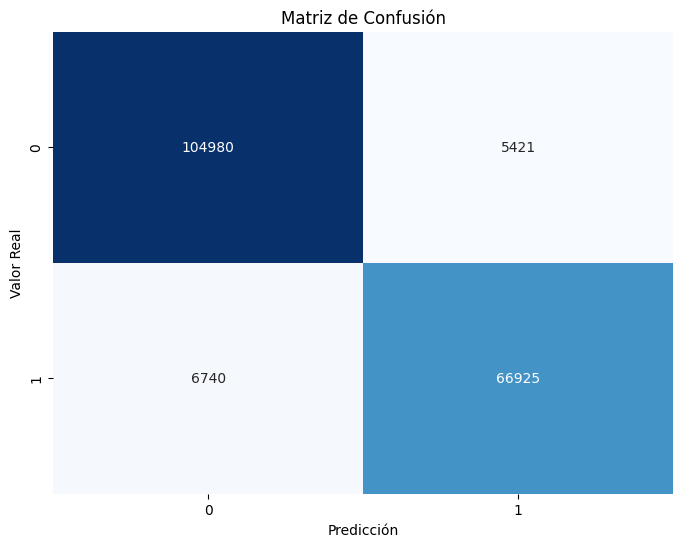

In [23]:
cm = confusion_matrix(y_test, test_predict)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

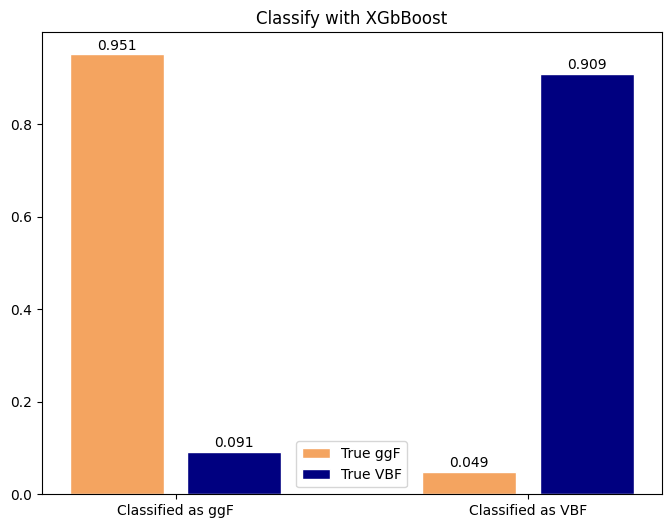

In [24]:
ggf_as_ggf = cm[0,0]
ggf_as_vbf = cm[0,1]
vbf_as_ggf = cm[1,0]
vbf_as_vbf = cm[1,1]
bars1 = np.array([ggf_as_ggf, ggf_as_vbf]) / (ggf_as_ggf+ggf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'ggf'].shape[0])
bars2 = np.array([vbf_as_ggf, vbf_as_vbf]) / (vbf_as_ggf+vbf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'vbf'].shape[0])
pos1 = [0,3]
pos2 = [1,4]
plt.figure(figsize=(8, 6))
plt.bar(pos1, bars1, width=.8, color='sandybrown', edgecolor='white', label='True ggF')
plt.bar(pos2, bars2, width=.8, color="navy", edgecolor='white', label='True VBF')
plt.xticks([.5,3.5] ,['Classified as ggF','Classified as VBF'])

for i in range(2):
     plt.text(pos1[i], bars1[i] + 0.01, str(round(bars1[i],3)), ha='center')
     plt.text(pos2[i], bars2[i] + 0.01, str(round(bars2[i],3)), ha='center')
plt.title("Classify with XGbBoost")
plt.legend()

In [25]:
print(classification_report(y_test, test_predict))


c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_exten

              precision    recall  f1-score   support

           0       0.94      0.95      0.95    110401
           1       0.93      0.91      0.92     73665

    accuracy                           0.93    184066
   macro avg       0.93      0.93      0.93    184066
weighted avg       0.93      0.93      0.93    184066



In [ ]:
params = { "n_estimators": 800,
            "max_depth": 12,
            "learning_rate": 0.5,
            "gamma": 0.6,
            "min_child_weight": 1,
            "reg_lambda": 100,
          #  "scale_pos_weight": scale_pos_weight,
            "eval_metric": ["logloss", "auc"],
            "early_stopping_rounds": 5,
            "objective":"binary:logistic",
            "verbosity": 1
            }


In [50]:
params_grid = { "n_estimators": 800,
            "max_depth": 12,
            "learning_rate": 0.5,
            "gamma": [0.1, 0.6, 2, 6],#, 100, 1000],
            "min_child_weight": [1, 20, 50],
            "reg_lambda": [10, 50, 100, 150],
            #"eval_metric": ["auc", "logloss"],
            # "scale_pos_weight":[scale_pos_weight/4, scale_pos_weight/2, scale_pos_weight],
            }

xbgClass_grid_cv = GridSearchCV(xgb.XGBClassifier(),
                                 {#'min_samples_split': np.linspace(0.1, 1.0, 10),
                                 'criterion': ['accuaracy'],
                                'max_depth':[12], 
                                'n_estimators':[800],
                                'learning_rate':[0.5],
                                "gamma": [0.1, 0.6, 2, 6],#, 100, 1000],
                                "min_child_weight": [1, 20, 50],
                                "reg_lambda": [10, 50, 100]},
                                cv=5,
                                n_jobs=-1).fit(X_train, y_train)

c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jav90\envs\dpj_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_exten

In [66]:
xbgClass_grid_cv.best_score_

0.9575682569194663

In [70]:
joblib.dump(xbgClass_grid_cv, 'gridsearchCV_xgbCLass_11_oct.pkl')

['gridsearchCV_xgbCLass_11_oct.pkl']

In [28]:
pkl_model = cloudpickle.load(open('gridsearchCV_xgbCLass_11_oct.pkl', 'rb'))
pkl_model.best_score_

UnpicklingError: invalid load key, '\x0d'.